<a href="https://colab.research.google.com/github/LinarKulinar/VortexBeamResearch/blob/main/(tmp)forming_vortex_beam_master_research_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Вихревые оптические пучки
## НИР Ахметов Линар 6133 2 семестр магистратуры
### Тема НИР: Распознавание мультиплексированных вихревых пучков с использованием нейронных сетей



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

Определим функцию *f*, которая задает значение поля в точке *(r, phi)* с учётом параметров *m∈ℤ* и σ∈ℜ.:

$ f(r, ϕ) = exp(-\cfrac{r^2}{σ^2}) \cdot r^{|m|} \cdot exp(i \cdot m \cdot ϕ) $

In [2]:
def f_with_tilt (r, phi, m, sigma, alpha):
    """
    Функция, описывающая входной пучок exp(i*m*phi)
    :param r: удаление точки от центра изображения
    :param phi: угол точки в исходном пучке
    :param m: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол отклонения оси линзы от линии распространения пучка
    :return значение функции в точке (r, phi)
    """
    x = r*math.cos(phi)
    y = r*math.sin(phi)  
    return math.exp(-(r/sigma)**2) * r**abs(m) * (math.cos(m * phi) + math.sin(m * phi)*1j) * (math.cos(alpha * x * y) + math.sin(alpha * x * y)*1j)

И функцию, создающую и вычисляющую значение функции *f(r, ϕ)* в каждой точке квадратного поля размером *(-size, size)*  с числом отсчётов, переданных в кортеже *matrix_shape*


$ tilt(r, ϕ) = exp(i \cdot α \cdot x \cdot y) $,

где $α$-малый угол наклона линзы

In [3]:
def get_field_with_tilt_and_control_size(image_size, vertex_size, matrix_shape, m, sigma, alpha):
    assert len(matrix_shape) == 2
    assert matrix_shape[0] % 2 == 1
    assert matrix_shape[1] % 2 == 1
    
    x_linspace = np.linspace(-image_size, image_size, matrix_shape[0])
    y_linspace = np.linspace(-image_size, image_size, matrix_shape[1]) 
    field = np.zeros(matrix_shape, dtype=complex)

    for i in range(matrix_shape[0]):
        for j in range(matrix_shape[1]):
            middle = min(matrix_shape) // 2
            di = i - middle
            dj = j - middle
            if abs(di) ** 2 + abs(dj) ** 2 <= middle ** 2:  # Если мы находимся внутри круга с радиусом, равным count/2
                phi = math.atan2(di, dj) # в полярных координатах
                r_coord = math.sqrt(x_linspace[i]**2 + y_linspace[j]**2)
                field[i,j] = f_with_tilt (r_coord, phi, m, sigma, alpha)
    return (field, x_linspace, y_linspace)

Определим функцию, формирующую изображения пучков из комплексного numpy-массива field

In [4]:
def plot_field(field, x_linspace, y_linspace):
    import matplotlib.cm as cmap
    extent = [np.max(y_linspace), np.min(y_linspace), np.min(x_linspace), np.max(x_linspace)] # для корректных чисел на осях графика
    factor_for_colorbar = 15 / 12 # сраная магия подбора для matplotlib
    height_of_image = 6 # константа, пропорциональная высоте картинки
    
    plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
    #plt.figure(figsize=(7.5, 6)) # только для квадратных картинок
    plt.imshow(np.absolute(field), cmap=cmap.hot, aspect='auto', extent=extent)
    plt.title("Амплитуда комплексного поля")
    plt.ylabel('y, расстояние (см)')
    plt.xlabel('x, расстояние (см)')
    plt.grid(True)
    plt.colorbar()
    #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
    plt.show()

    plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
    plt.imshow(np.absolute(field)**2, cmap=cmap.hot, aspect='auto', extent=extent)
    plt.title("Интенсивность комплексного поля")
    plt.ylabel('y, расстояние (см)')
    plt.xlabel('x, расстояние (см)')
    plt.grid(True)
    plt.colorbar()
    #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
    plt.show()

    plt.figure(figsize=(factor_for_colorbar * height_of_image * field.shape[1]/field.shape[0], height_of_image))
    plt.imshow(np.angle(field), cmap=cmap.hot, aspect='auto', extent=extent)
    plt.title("Фаза комплексного поля")
    plt.ylabel('y, расстояние (см)')
    plt.xlabel('x, расстояние (см)')
    plt.grid(True)
    plt.colorbar()
    #plt.savefig("num_i="+str(num_i)+" num_m="+str(num_m)+"/Распредление по радиусу во время 0,5t")
    plt.show()

Вызовем вышеописанные функции для отображения пучка *m = 3* и числом отчётов, равным *101* по горизонтали и вертикали 

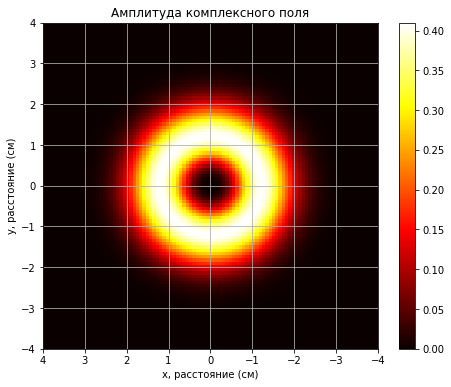

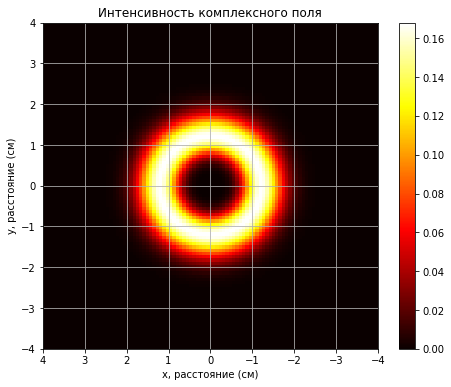

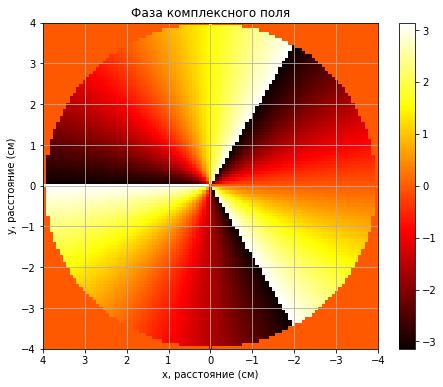

In [5]:
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=4, vertex_size=1, matrix_shape=(101, 101), m=3, sigma=1, alpha=0)
plot_field(field, x_linspace, y_linspace)

## Определим функцию, которая дополняет нулями исходную картинку:

In [6]:
def get_field_padded_zeros(field, new_shape, x_linspace, y_linspace):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param field: изображение
    :param new_shape: новые размеры изображения
    :param x_linspace: размеры входного изображения (в см/м/мм)
    :param y_linspace: размеры входного изображения (в см/м/мм)
    """
    assert len(field.shape) == 2
    assert field.shape[0] % 2 == 1
    assert field.shape[1] % 2 == 1
    
    assert len(new_shape) == 2
    assert new_shape[0] % 2 == 1
    assert new_shape[1] % 2 == 1
    
    field_padded_zeros = np.zeros(new_shape, dtype=field.dtype)
    #print(field_padded_zeros)
    
    diff0dimetional=(new_shape[0]-field.shape[0])//2
    #print("diff0dimetional =",diff0dimetional)
    diff1dimetional=(new_shape[1]-field.shape[1])//2
    #print("diff1dimetional =",diff1dimetional)
    
    if (diff0dimetional >= 0 and diff1dimetional >= 0):  
        #print("slicesindex=[",diff0dimetional, ":", new_shape[0]-diff0dimetional, ",", diff1dimetional, ":", new_shape[1]-diff1dimetional,"]")
        field_padded_zeros[diff0dimetional : new_shape[0]-diff0dimetional, diff1dimetional : new_shape[1]-diff1dimetional] = field
    else:
        if (diff0dimetional <= 0 and diff1dimetional <= 0):
            #print("slicesindex=[",-diff0dimetional, ":", field.shape[0]+diff0dimetional, ",", -diff1dimetional, ":", field.shape[1]+diff1dimetional,"]")
            field_padded_zeros = field[-diff0dimetional : field.shape[0]+diff0dimetional, -diff1dimetional : field.shape[1]+diff1dimetional]
        else:
            raise ValueError("Код не предусматривает, что необходимо дополнять нулями по одной оси и обрезать по другой. Реализация подразумевает, что можно либо дополнять нулями либо обрезать")
    #пересчитываем linspace:
    x_linspace_padded_zeros = x_linspace / field.shape[0] * new_shape[0]
    y_linspace_padded_zeros = y_linspace / field.shape[1] * new_shape[1]
    return (field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)
    
# For tests
# get_field_padded_zeros(np.array([[4]]), (7,7), np.array([-1,1]), np.array([-2,2]))
# get_field_padded_zeros(np.array([[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3],[4,4,4,4,4],[5,5,5,5,5]]), (7,5), np.array([-1,1]), np.array([-2,2]))

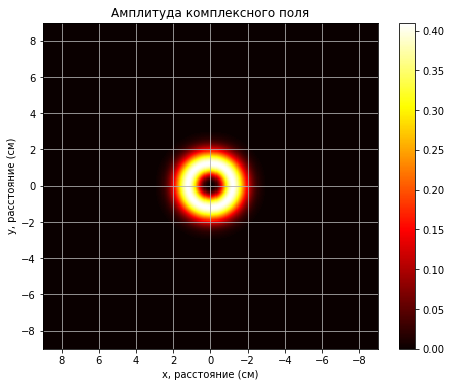

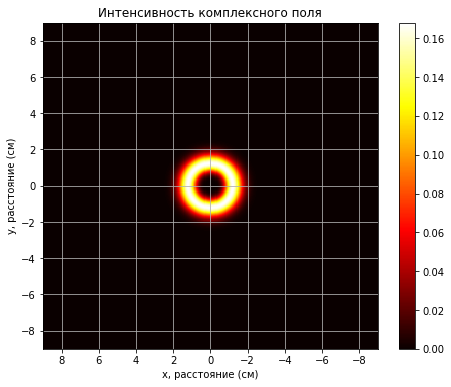

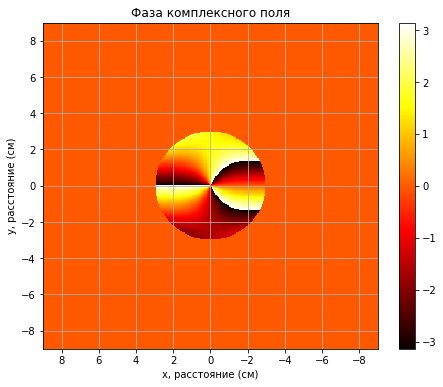

In [7]:
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=3, vertex_size=1, matrix_shape=(101, 101), m=3, sigma=1, alpha=0.5)
field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (303, 303), x_linspace, y_linspace)
plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

## Экспериментируем с FFT

Размер выходного поля b = 1.6833333333333333


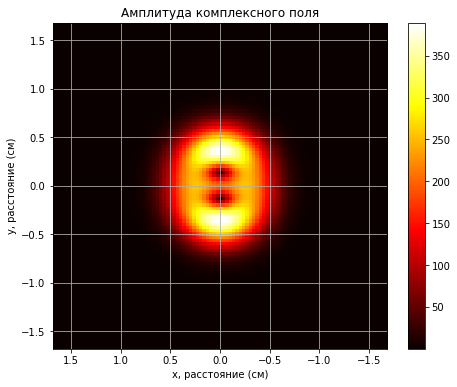

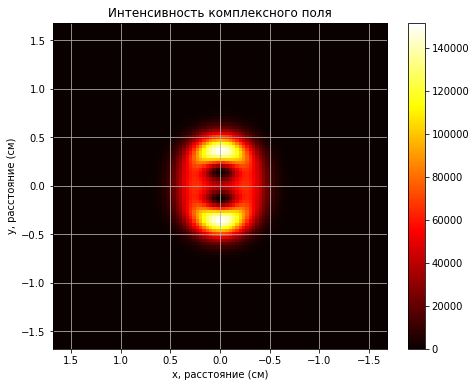

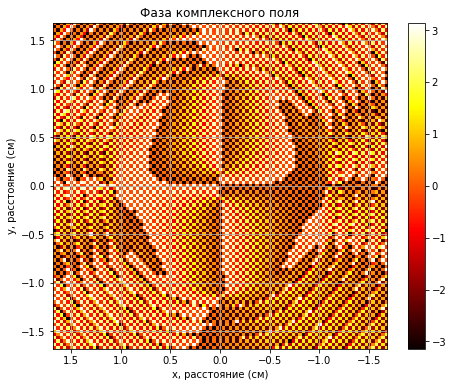

In [8]:
# Параметры, с которыми будет выполняться код
a=3 # Размер исходного поля
N=101 # Число отсчётов картинки, поле которой мы генерируем
M=505 # Число отсчётов, до которого дополняем поле до fft2
b=N*N/4/a/M # Размер выходного поля после fft2 (с допущением, что длина волны обратно пропорциональна фокусному расстоянию)
print("Размер выходного поля b =",b)

# Генерируем поле лазера
field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=2, sigma=1, alpha=0.5)
field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (M, M), x_linspace, y_linspace)
# Отприсовываем получившееся поле 
#plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

# Выполняем fft2 преобразование (+ расщитываем масштаб)
field_after_fft = np.fft.fft2(field_padded_zeros)
field_after_fft = np.fft.fftshift(field_after_fft)
# Отрезаем поле размером NxN
field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
# Перерасчитываем масштаб поля после fft 
x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
# Отрисовываем картинки после fft2
plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)

### Определим функцию, которая выдает картинку после fft

Размер выходного поля b = 1.6833333333333333


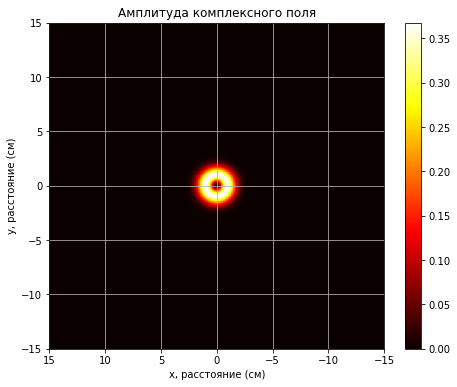

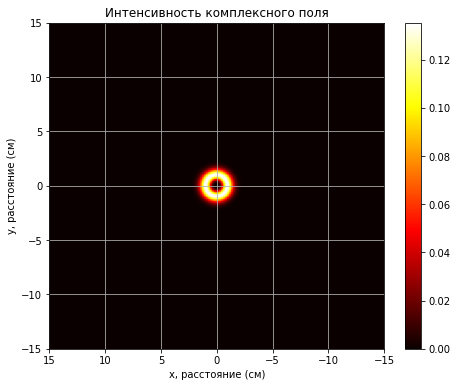

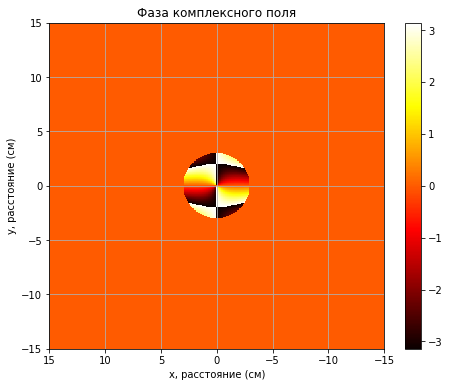

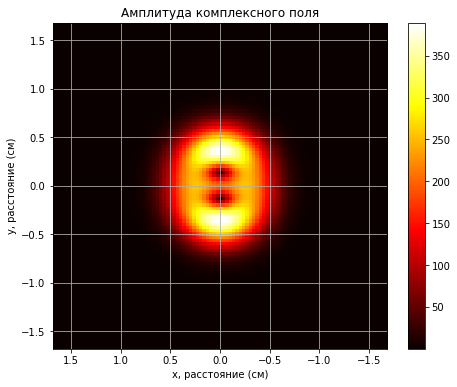

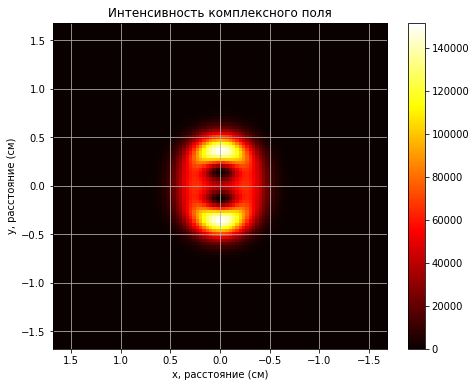

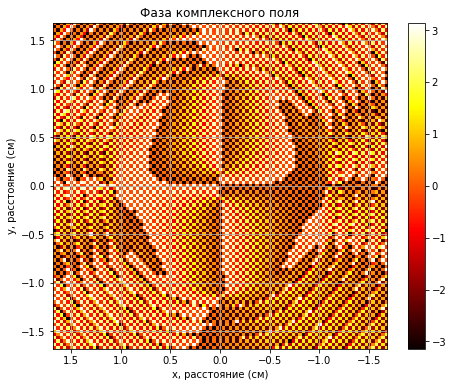

In [9]:
def get_field_after_tilt_and_fft(a, N, M, m, sigma, alpha):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param a: Размер исходного поля
    :param N: Число отсчётов картинки, поле которой мы генерируем
    :param M: Число отсчётов, до которого дополняем поле до fft2
    :param m: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол отклонения оси линзы от линии распространения пучка
    :return ((field, x_linspace, y_linspace),(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2))
    """
    b=N*N/4/a/M # 
    print("Размер выходного поля b =",b)
 
    # Генерируем поле лазера
    field, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=m, sigma=sigma, alpha=alpha)
    field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (M, M), x_linspace, y_linspace)
    # Отприсовываем получившееся поле 
    #plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

    # Выполняем fft2 преобразование (+ расщитываем масштаб)
    field_after_fft = np.fft.fft2(field_padded_zeros)
    field_after_fft = np.fft.fftshift(field_after_fft)
    # Отрезаем поле размером NxN
    field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
    # Перерасчитываем масштаб поля после fft 
    x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
    y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
    # Отрисовываем картинки после fft2
    #plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)
    
    return ((field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros),(field_after_fft, x_linspace_after_fft, y_linspace_after_fft))


(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_field_after_tilt_and_fft(a=3, N=101, M=505, m=2, sigma=1, alpha=0.5)
plot_field(field, x_linspace, y_linspace)
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2)

### Обобщим функцию get_field_after_tilt_and_fft для массива m и весов c

Размер выходного поля b = 1.6833333333333333


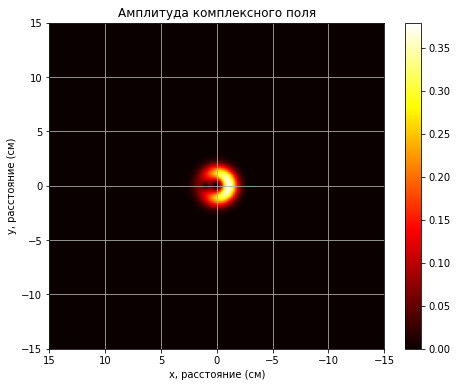

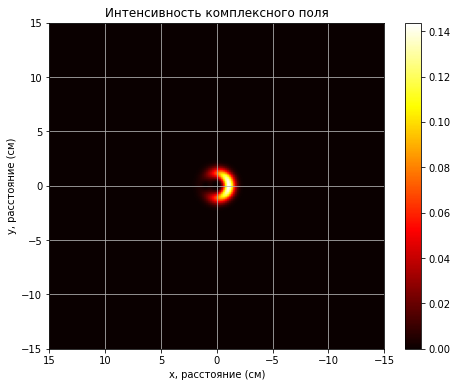

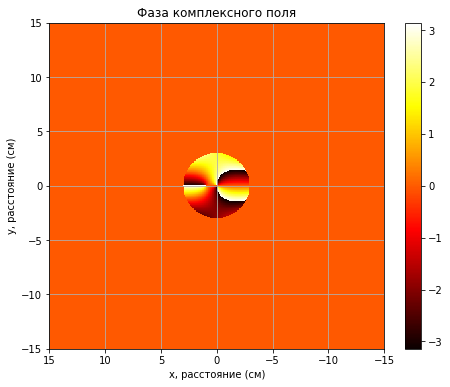

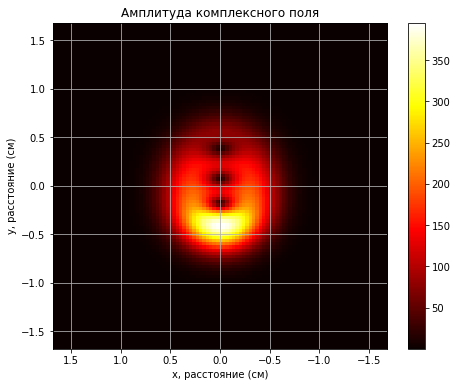

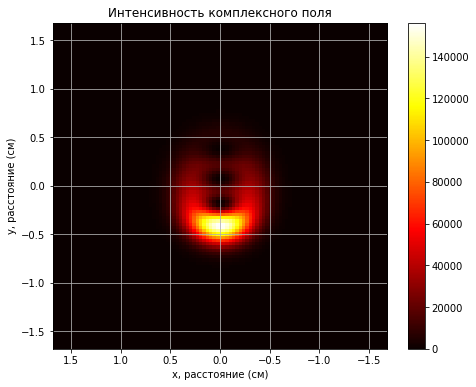

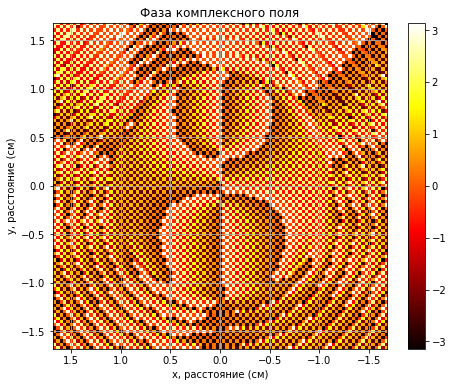

In [10]:
def get_superposition_field_after_tilt_and_fft(a, N, M, m, c, sigma, alpha):
    """
    Дополняет двухмерное изображение нулями до размера new_shape, если new_shape больше размера картини. Обрезает изображение до размера new_shape, если new_shape меньше размера картинки.
    Если по одной оси надо обрезать, а по второй дополнить нулями, выкинется ValueError
    :param a: Размер исходного поля
    :param N: Число отсчётов картинки, поле которой мы генерируем
    :param M: Число отсчётов, до которого дополняем поле до fft2
    :param m: параметр пучка - угловой орбительный момент
    :param c: параметр пучка - угловой орбительный момент
    :param sigma: параметр пучка - радиус перетяжки
    :param alpha: параметр линзы, сквозь который проходит пучок - угол отклонения оси линзы от линии распространения пучка
    :return ((field, x_linspace, y_linspace),(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2))
    """
    b=N*N/4/a/M # 
    print("Размер выходного поля b =",b)

    assert len(m)==len(c) 
    assert sum(c)>=1-1e-8 and sum(c)<=1+1e-8 # Сумма весов должна быть равна 1
    field_superposition = np.zeros((N,N), dtype=field.dtype) # Суперпозиция полей с разных m
    for m_i, c_i in zip(m, c):
        # Генерируем поле лазера
        field_i, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=m_i, sigma=sigma, alpha=alpha)
        field_superposition+=c_i*field_i
    field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field_superposition, (M, M), x_linspace, y_linspace)
    # Отприсовываем получившееся поле 
    #plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

    # Выполняем fft2 преобразование (+ расщитываем масштаб)
    field_after_fft = np.fft.fft2(field_padded_zeros)
    field_after_fft = np.fft.fftshift(field_after_fft)
    # Отрезаем поле размером NxN
    field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
    # Перерасчитываем масштаб поля после fft 
    x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
    y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
    # Отрисовываем картинки после fft2
    #plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)
    
    return ((field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros),(field_after_fft, x_linspace_after_fft, y_linspace_after_fft))


(field, x_linspace, y_linspace), (field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2) = get_superposition_field_after_tilt_and_fft(a=3, N=101, M=505, m=[2,3], c=[0.5, 0.5], sigma=1, alpha=0.5)
plot_field(field, x_linspace, y_linspace)
plot_field(field_after_fft2, x_linspace_after_fft2, y_linspace_after_fft2)

In [11]:
# # Параметры, с которыми будет выполняться код
# a=3 # Размер исходного поля
# N=101 # Число отсчётов картинки, поле которой мы генерируем
# M=505 # Число отсчётов, до которого дополняем поле до fft2
# b=N*N/4/a/M # Размер выходного поля после fft2 (с допущением, что длина волны обратно пропорциональна фокусному расстоянию)
# print("Размер выходного поля b =",b)

# # Генерируем поле лазера
# field1, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=2, sigma=1, alpha=0.5)
# field2, x_linspace, y_linspace = get_field_with_tilt_and_control_size(image_size=a, vertex_size=a, matrix_shape=(N, N), m=3, sigma=1, alpha=0.5)
# field = (field1 + field2)/2
# field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros = get_field_padded_zeros(field, (M, M), x_linspace, y_linspace)
# # Отприсовываем получившееся поле 
# #plot_field(field_padded_zeros, x_linspace_padded_zeros, y_linspace_padded_zeros)

# # Выполняем fft2 преобразование (+ расщитываем масштаб)
# field_after_fft = np.fft.fft2(field_padded_zeros)
# field_after_fft = np.fft.fftshift(field_after_fft)
# # Отрезаем поле размером NxN
# field_after_fft = get_field_padded_zeros(field_after_fft, (N, N), x_linspace, y_linspace)[0]
# # Перерасчитываем масштаб поля после fft 
# x_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[0])
# y_linspace_after_fft = np.linspace(-b, b, field_after_fft.shape[1])
# # Отрисовываем картинки после fft2
# plot_field(field_after_fft, x_linspace_after_fft, y_linspace_after_fft)